In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#!pip install tensorflow==2.5

In [ ]:
from keras.models import Input, Model,Sequential
from keras.layers import Conv2D,Concatenate, MaxPool2D,MaxPooling2D,Conv2DTranspose
from keras.layers import UpSampling2D,Dropout,Activation,BatchNormalization,concatenate
from keras.layers.convolutional import Conv2DTranspose
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from  tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
import random
import time
import random as r
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!ls /gdrive/MyDrive/pso-UNET/

isles2018.ipynb		MTT  pso_UNET.ipynb  train     UNET
ISLES2018_Training.zip	PSO  test	     TRAINING  val


In [ ]:
#!unzip "/gdrive/MyDrive/pso-UNET/ISLES2018_Training.zip" -d "/gdrive/MyDrive/pso-UNET/"


In [ ]:
!ls /gdrive/MyDrive/pso-UNET/TRAINING/case_1

SMIR.Brain.XX.O.CT.345562	 SMIR.Brain.XX.O.CT_MTT.345565
SMIR.Brain.XX.O.CT_4DPWI.345561  SMIR.Brain.XX.O.CT_Tmax.345567
SMIR.Brain.XX.O.CT_CBF.345563	 SMIR.Brain.XX.O.OT.345566
SMIR.Brain.XX.O.CT_CBV.345564


In [ ]:
yol_1='/gdrive/MyDrive/pso-UNET/TRAINING/'
mtt='/gdrive/MyDrive/pso-UNET/MTT/'
ct='/gdrive/MyDrive/pso-UNET/CT/'
ot='/gdrive/MyDrive/pso-UNET/OT/'
cbv='/gdrive/MyDrive/pso-UNET/CBV/'
cbf='/gdrive/MyDrive/pso-UNET/CBF/'
tmax='/gdrive/MyDrive/pso-UNET/Tmax/'
yol_2='/gdrive/MyDrive/pso-UNET/iskemi/'
results_path='/gdrive/MyDrive/pso-UNET/results/'

In [ ]:
!pip install SimpleITK
import SimpleITK
import skimage
import skimage.io as io
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaler = MinMaxScaler()
import imageio

     |████████████████████████████████| 48.4 MB 1.1 MB/s 


In [ ]:

MTT_path=sorted(glob.glob(yol_1+"**/*.CT_MTT.*.nii",recursive=True))
CBV_path=sorted(glob.glob(yol_1+"**/*.CT_CBV.*.nii",recursive=True))
CBF_path=sorted(glob.glob(yol_1+"**/*.CT_CBF.*.nii",recursive=True))
Tmax_path=sorted(glob.glob(yol_1+"**/*.CT_Tmax.*.nii",recursive=True))
CT_path=sorted(glob.glob(yol_1+"**/*.CT.*.nii",recursive=True))
OT=sorted(glob.glob(yol_1+"**/*.OT.*.nii",recursive=True))

## DATA READY

In [ ]:
"""def train_array(path,end,yol):
    files = sorted(glob.glob(path+end,recursive=True))
    img_liste = []
    for file in files:
        img = nib.load(file).get_fdata()
        img=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        img=img.astype(np.float32)
        
            
        
        np.save(yol+str(file).split('.')[-2]+'.npy', img)   
        
        img_liste.append(np.array(img))
  
      
       
        #img_liste.append(img)
    #img_liste = np.array(img_liste)     
    return (img_liste)"""

In [ ]:
def train_array(path,end,yol):
    files = sorted(glob.glob(path+end,recursive=True))
    img_liste = []
    for file in files:
        img = nib.load(file).get_fdata()
        img=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        
        img=img.astype(np.float32)
        
        for slice in range(0,img.shape[2]):
            img_s = img[:,:,slice]
            img_s = np.expand_dims(img_s,axis=2)
            
            
            img_liste.append(np.rot90(np.array(img_s)))
        for i in range(len(img_liste)):

            np.save(yol+str(i)+'.npy',img_liste[i]) 

      
        
        
     
        #img_liste.append(np.rot90(np.array(img)))
       
      
       
        #img_liste.append(img)
    #img_liste = np.array(img_liste)     
    return (img_liste)

In [ ]:
def mask_array(path,end,yol):
    files = sorted(glob.glob(path+end,recursive=True))
    img_liste = []
    for file in files:
        img = nib.load(file).get_fdata()
        #img=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        img=img.astype(np.float32)
        for slice in range(0,img.shape[2]):
            img_s = img[:,:,slice]
            img_s = np.expand_dims(img_s,axis=2)
            #np.save(yol+str(slice)+'.npy',np.rot90(np.array(img_s))) 
            
            
            img_liste.append(np.rot90(np.array(img_s)))
        for i in range(len(img_liste)):

              np.save(yol+str(i)+'.npy',img_liste[i]) 
            


      
        
        
        #img_liste.append(np.array(img))
       
      
       
        #img_liste.append(img)
    #img_liste = np.array(img_liste)     
    return (img_liste)

In [ ]:
MTT=train_array(yol_1,"**/*.CT_MTT.*.nii",mtt)
CBV=train_array(yol_1,"**/*.CT_CBV.*.nii",cbv)
CBF=train_array(yol_1,"**/*.CT_CBF.*.nii",cbf)
Tmax=train_array(yol_1,"**/*.CT_Tmax.*.nii",tmax)
CT=train_array(yol_1,"**/*.CT.*.nii",ct)
OT=mask_array(yol_1,"**/*.OT.*.nii",ot)

In [ ]:
"""from PIL import Image
img = nib.load(MTT_path[0]).get_fdata()
for plane in range(img.shape[2]):
    p = img[:,:,plane].astype(np.uint8)
    imgg = Image.fromarray(p)
    imgg.save( mtt+f'plane{plane}.png' )"""

"from PIL import Image\nimg = nib.load(MTT_path[0]).get_fdata()\nfor plane in range(img.shape[2]):\n    p = img[:,:,plane].astype(np.uint8)\n    imgg = Image.fromarray(p)\n    imgg.save( mtt+f'plane{plane}.png' )"

In [ ]:
#MTT=train_array(yol_1,"**/*.CT_MTT.*.nii",mtt)

In [ ]:
#MTT=train_array(yol_1,"**/*.CT_MTT.*.nii",mtt)


In [ ]:
len(MTT),len(OT),type(MTT[0]),np.unique(MTT[0]),MTT[0].shape

(502,
 502,
 numpy.ndarray,
 array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375,
        0.04  , 0.0425, 0.045 , 0.0475, 0.05  , 0.0525, 0.055 , 0.0575,
        0.06  , 0.0625, 0.065 , 0.0675, 0.07  , 0.0725, 0.075 , 0.0775,
        0.08  , 0.0825, 0.085 , 0.0875, 0.09  , 0.0925, 0.095 , 0.0975,
        0.1   , 0.1025, 0.105 , 0.1075, 0.11  , 0.1125, 0.115 , 0.1175,
        0.12  , 0.1225, 0.125 , 0.1275, 0.13  , 0.1325, 0.135 , 0.1375,
        0.14  , 0.1425, 0.145 , 0.1475, 0.15  , 0.1525, 0.155 , 0.1575,
        0.16  , 0.1625, 0.165 , 0.1675, 0.17  , 0.1725, 0.175 , 0.1775,
        0.18  , 0.1825, 0.185 , 0.1875, 0.19  , 0.1925, 0.195 , 0.1975,
        0.2   , 0.2025, 0.205 , 0.2075, 0.21  , 0.2125, 0.215 , 0.2175,
        0.22  , 0.2225, 0.225 , 0.2275, 0.23  , 0.2325, 0.235 , 0.2375,
        0.24  , 0.2425, 0.245 , 0.2475, 0.25  , 0.2525, 0.255 , 0.2575,
        0.26  , 0.2625, 0.265 , 0.26

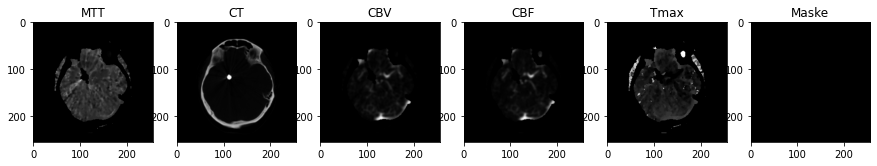

In [ ]:
k=0
renk={0:'magma',
      1:'viridis',
      2:'gray',
      3:'inferno',
      4:'cividis',
      5:'hot'}
a=2
  
plt.figure(figsize=(15, 9))
plt.subplot(261)
plt.title('MTT')
plt.imshow(MTT[k].reshape(256,256),cmap=renk[a])
plt.subplot(262)
plt.title('CT')
plt.imshow(CT[k].reshape(256,256), cmap=renk[a])
plt.subplot(263)
plt.title('CBV')
plt.imshow(CBV[k].reshape(256,256), cmap=renk[a])
plt.subplot(264)
plt.title('CBF')
plt.imshow(CBF[k].reshape(256,256), cmap=renk[a])
plt.subplot(265)
plt.title('Tmax')
plt.imshow(Tmax[k].reshape(256,256), cmap=renk[a])
plt.subplot(266)
plt.title('Maske')
plt.imshow(OT[k].reshape(256,256), cmap=renk[a])

## DATA CLEANING

In [ ]:
del_list=[]
for i in range(len(OT)):
  
  
  if np.unique(OT[i]).shape[0]==1:
    del_list.append(i)
   
    
    print(i,",")

In [ ]:
len(del_list)

196

In [ ]:
del_list[13]

88

In [ ]:
import os

In [ ]:

def remove_img(yol):

  dell=[]
  for i in range(len(del_list)):
    files=glob.glob(yol+"**/*.npy",recursive=True)
    a=files[del_list[i]]
    dell.append(a)
  for i in dell:

    os.remove(i)
  return dell


In [ ]:
remove_img(mtt)

In [ ]:
remove_img(cbv)
remove_img(cbf)
remove_img(ct)
remove_img(ot)
remove_img(tmax)



In [ ]:
files=sorted(glob.glob(ct+"**/*.npy",recursive=True))
len(files)


306

In [ ]:
files=sorted(glob.glob(ot+"**/*.npy",recursive=True))


In [ ]:

files[1]

'/gdrive/MyDrive/pso-UNET/OT/10.npy'

In [ ]:
def read_data(yol):
  files=sorted(glob.glob(yol+"**/*.npy",recursive=True))
  img_liste=[]
  for i in files:
    img=np.load(i)
    img_liste.append(np.array(img))
  return img_liste



In [ ]:
MTT=read_data(mtt)
CT=read_data(ct)
OT=read_data(ot)
CBV=read_data(cbv)
CBF=read_data(cbf)
TMax=read_data(tmax)


In [ ]:
OT[10]

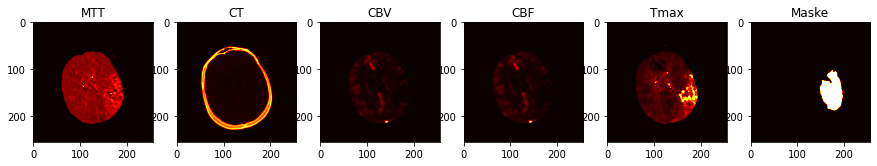

In [ ]:
k=12
renk={0:'magma',
      1:'viridis',
      2:'gray',
      3:'inferno',
      4:'cividis',
      5:'hot'}
a=5
  
plt.figure(figsize=(15, 9))
plt.subplot(261)
plt.title('MTT')
plt.imshow(MTT[k].reshape(256,256),cmap=renk[a])
plt.subplot(262)
plt.title('CT')
plt.imshow(CT[k].reshape(256,256), cmap=renk[a])
plt.subplot(263)
plt.title('CBV')
plt.imshow(CBV[k].reshape(256,256), cmap=renk[a])
plt.subplot(264)
plt.title('CBF')
plt.imshow(CBF[k].reshape(256,256), cmap=renk[a])
plt.subplot(265)
plt.title('Tmax')
plt.imshow(TMax[k].reshape(256,256), cmap=renk[a])
plt.subplot(266)
plt.title('Maske')
plt.imshow(OT[k].reshape(256,256), cmap=renk[a])

In [ ]:
len(OT),len(CBV),len(CT),len(TMax),len(MTT),len(CBF)

(306, 306, 306, 306, 306, 306)

## DATA AUGMENTATION


In [ ]:

dataa=np.concatenate((MTT,TMax,CBF,CBV),axis=3)

dataa.shape

(306, 256, 256, 4)

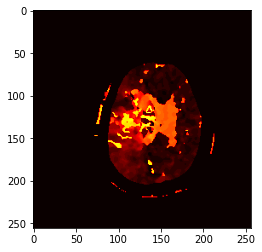

In [ ]:
plt.imshow(dataa[195,:,:,1],cmap="hot")

In [ ]:
def augment_data(images, masks, augment=True):
    H = 256
    W = 256
    save_image_list = []
    save_mask_list = []
    for x, y in tqdm(zip(images, masks), total=len(images)):
        # name = x.split("/")[-1].split(".")
        # """ Extracting the name and extension of the image and the mask. """
        # image_name = name[0]
        # image_extn = name[1]

        # name = y.split("/")[-1].split(".")
        # mask_name = name[0]
        # mask_extn = name[1]

        # """ Reading image and mask. """
        # #x = cv2.imread(x, cv2.IMREAD_COLOR)
        # #y = cv2.imread(y, cv2.IMREAD_COLOR)
        # x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        # y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Augmentation """
        if augment == True:
            #aug = CenterCrop(H, W, p=1.0)
            #augmented = aug(image=x, mask=y)
            #x1 = augmented["image"]
            #y1 = augmented["mask"]

            #aug = RandomRotate90(p=1.0)
            #augmented = aug(image=x, mask=y)
            #x2 = augmented['image']
            #y2 = augmented['mask']

            #aug = GridDistortion(p=1.0)
            #augmented = aug(image=x, mask=y)
            #x3 = augmented['image']
            #y3 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            #aug = VerticalFlip(p=1.0)
            #augmented = aug(image=x, mask=y)
            #x5 = augmented['image']
            #y5 = augmented['mask']

            # save_images = [x, x1, x2, x3, x4, x5]
            # save_masks =  [y, y1, y2, y3, y4, y5]

            save_images = [x4]
            save_masks =  [y4]

            #save_image_list.append(x1)
            #save_image_list.append(x2)
            #save_image_list.append(x3)
            save_image_list.append(x4)
            #save_image_list.append(x5)

            #save_mask_list.append(y1)
            #save_mask_list.append(y2)
            #save_mask_list.append(y3)
            save_mask_list.append(y4)
            #save_mask_list.append(y5)


        else:
            save_images = [x]
            save_masks = [y]

        # """ Saving the image and mask. """
        # idx = 1
        # for i, m in zip(save_images, save_masks):
        #     i = cv2.resize(i, (IMG_WIDTH, IMG_HEIGHT))
        #     m = cv2.resize(m, (IMG_WIDTH, IMG_HEIGHT))

        #     if len(images) == 1:
        #         tmp_img_name = f"{image_name}.{image_extn}"
        #         tmp_mask_name = f"{mask_name}.{mask_extn}"

        #     else:
        #         tmp_img_name = f"{image_name}_{idx}.{image_extn}"
        #         tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

        #     image_path = os.path.join(save_path, "images", tmp_img_name)
        #     mask_path = os.path.join(save_path, "masks", tmp_mask_name)

        #     cv2.imwrite(image_path, i)
        #     cv2.imwrite(mask_path, m)

        #     idx += 1
    return save_image_list, save_mask_list

In [ ]:
augmented_images, augmented_masks = augment_data(dataa, OT)

100%|██████████| 306/306 [00:00<00:00, 1517.99it/s]


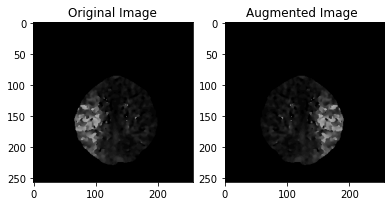

In [ ]:
idxx = 5

plt.figure(figsize=(20, 16))

plt.subplot(161)
plt.title('Original Image')
plt.imshow(dataa[10,:,:,1], cmap='gray')

plt.subplot(162)
plt.title('Augmented Image ')
plt.imshow(augmented_images[10][:,:,1], cmap='gray')

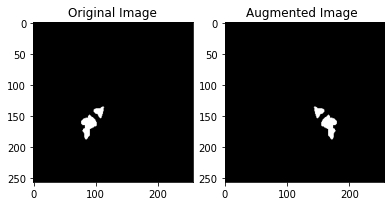

In [ ]:
idxx = 5

plt.figure(figsize=(20, 16))

plt.subplot(161)
plt.title('Original Image')
plt.imshow(OT[10].reshape(256,256), cmap='gray')

plt.subplot(162)
plt.title('Augmented Image ')
plt.imshow(augmented_masks[10].reshape(256,256), cmap='gray')

In [ ]:
augmented_images[12].shape, MTT[12].shape

((256, 256, 4), (256, 256, 1))

In [ ]:
len(augmented_images)

306

In [ ]:
iskemi = np.concatenate([dataa, augmented_images], axis = 0)
masks = np.concatenate([OT, augmented_masks], axis = 0)



In [ ]:
OT = np.concatenate([OT], axis = 1)

In [ ]:
len(dataa),len(OT)

(306, 306)

## TRAIN-TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(iskemi, masks, test_size = 0.20, random_state = 42)

#Further split training data t a smaller subset for quick testing of models
X_test, X_val, y_test, y_val= train_test_split(X_val, y_val, test_size = 0.20, random_state = 42)

In [ ]:
X_train.shape,X_test.shape,X_val.shape,y_train.shape

((489, 256, 256, 4), (98, 256, 256, 4), (25, 256, 256, 4), (489, 256, 256, 1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataa, OT, test_size = 0.15, random_state = 42)

#Further split training data t a smaller subset for quick testing of models
X_test, X_val, y_test, y_val= train_test_split(X_val, y_val, test_size = 0.20, random_state = 42)

## MODEL

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred): # 2 görseli üst üste koyduğumuzda pixel farkı veriyor 
    return 1-dice_coef(y_true, y_pred)

In [ ]:
callbacks =  [ModelCheckpoint(filepath=results_path, 
                            monitor='val_loss', 
                            mode='min',
                            
                            save_best_only=True,
                            save_weights_only=True,
                            ),
              EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)]

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    
    x =Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('elu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('elu')(x)
   
    return x
  
def get_unet(input_img, n_filters = 16, dropout = .5, noise_shape=None, seed=None, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [ ]:
input_img = Input((256, 256, 4))
model = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data = (X_val,y_val),
                    shuffle=True,
                    callbacks=callbacks
                    )

In [ ]:
scores = model.evaluate(X_test, y_test,verbose = 1)

In [ ]:
model.save('/gdrive/MyDrive/pso-UNET/UNET/')

NameError: ignored

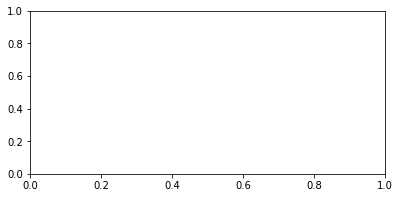

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
    
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### PSO-UNET

In [ ]:
EPOCHS = 100 # number of total iteration
PARTICLE_EPOCHS = 5 # number of each particle iteration
BATCH_SIZE = 4 # Size of batches to train on
W = 0.5 # 0.4
C_1 = 0.8 # 0.6
C_2 = 1.0 # 1.0

class particle():
  def __init__(self, particle_num,particle,X_train,y_train):
    self.particle_id=particle_num #particle_id kontrolü için
    self.particle_model=particle #parçacık modeli başlangıcı
    #en iyi modelin başlangıcı
    self.local_best_model=particle
    self.global_best_model=particle

    #en iyi skor başlangıcı
    self.local_best_score = 0.0
    self.global_best_score = 0.0
    self.x = X_train
    self.y = y_train
    self.parm = {'W':W, 'C_1':C_1, 'C_2':C_2}
    self.velocities = [None] * len(particle.get_weights())

    for i, layer in enumerate(particle.get_weights()):
      self.velocities[i] = np.random.rand(*layer.shape) / 5 - 0.10
  def data_generator(self,X_train, y_train, batch_size):


    
    image_generator = ImageDataGenerator().flow(X_train, X_train, batch_size, seed = 42)
    mask_generator = ImageDataGenerator().flow(y_train, y_train, batch_size, seed = 42)
    while True:
        x_batch, _ = image_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch


  def train_particle(self):
        print("particle {}/{} fitting".format(self.particle_id+1, 10))

        # her epoch ta ağırlıkların ayarlanması
        step_model = self.particle_model
        step_weight = step_model.get_weights()
        
        # new_velocities = [None] * len(step_weight)
        new_weight = [None] * len(step_weight)
        local_rand, global_rand = random.random(), random.random()

        # PSO algorithm applied to weights
        for index, layer in enumerate(step_weight):
            new_v = self.parm['W'] * self.velocities[index]
            new_v = new_v + self.parm['C_1'] * local_rand * (self.local_best_model.get_weights()[index] - layer)
            new_v = new_v + self.parm['C_2'] * global_rand * (self.global_best_model.get_weights()[index] - layer)
            self.velocities[index] = new_v
            new_weight[index] = step_weight[index] + self.velocities[index]

        step_model.set_weights(new_weight)
        
        save_model_path = 'checkpoint/checkpoint_particle_{}'.format(self.particle_id)
        mc = [ModelCheckpoint(filepath=save_model_path, 
                            monitor='val_loss', 
                            mode='min',
                            
                            save_best_only=True,
                            save_weights_only=True,
                            ),
              EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)]
        hist = step_model.fit(self.data_generator(X_train,y_train,8),
                steps_per_epoch =len(X_train)/8,
                epochs=PARTICLE_EPOCHS,
                #batch_size=BATCH_SIZE,
                verbose=1,
                shuffle=True,
                
                validation_data =(X_val,y_val),
                callbacks=[mc],
                )
        
        # train_score_acc = hist.history['accuracy'][-1]
        train_score_loss = hist.history['val_loss'][-1]

        step_model.load_weights(save_model_path)
        self.particle_model = step_model

        # if self.global_best_score <= train_score_acc:
        if self.global_best_score >= train_score_loss:
            self.local_best_model = step_model
            
        return self.particle_id, train_score_loss
    
  def update_global_model(self, global_best_model, global_best_score):
        if self.local_best_score < global_best_score:    
            self.global_best_model = global_best_model
            self.global_best_score = global_best_score

  def resp_best_model(self, gid):
        if self.particle_id == gid:
            return self.particle_model






In [ ]:
DROP_RATE = 0
def get_best_score_by_loss(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 100000
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score > result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


def get_best_score_by_acc(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 0
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score < result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


if __name__ == "__main__":
  

    server_model =get_unet(input_img, n_filters=16, dropout=0.5,  batchnorm=True)

    #print(server_model.summary())


    pso_model = []
    for i in range(10):
        pso_model.append(particle(particle_num=i, particle=get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True), X_train=X_train, y_train=y_train))

    server_evaluate_acc = []
    global_best_model = None
    global_best_score = 0.0

    for epoch in range(EPOCHS):
        server_result = []
        start = time.time()

        for particle in pso_model:
            if epoch != 0:
                particle.update_global_model(server_model, global_best_score)
            
            #local_model, train_score = client.train_particle()
            # server_result.append([local_model, train_score])
            pid, train_score = particle.train_particle()
            rand = random.randint(0,99)

            # Sunucuya rastgele bırakılan veriler
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_result.append([pid, train_score])
        
       # En iyi puan karşılaştırmasından sonra her image için en uygun modeli gönderin
        gid, global_best_score = get_best_score_by_loss(server_result)
        for particle in pso_model:
            if particle.resp_best_model(gid) != None:
                global_best_model = particle.resp_best_model(gid)

        server_model = global_best_model
        
        print("server {}/{} evaluate".format(epoch+1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1))
        server_model.save('/gdrive/MyDrive/pso-UNET/PSO/')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
61/61 [==============================] - 4s 64ms/step - loss: 0.2729 - dice_coef: 0.7300 - val_loss: 0.2923 - val_dice_coef: 0.7077
particle 7/10 fitting
Epoch 1/5
61/61 [==============================] - 4s 67ms/step - loss: 0.2754 - dice_coef: 0.7258 - val_loss: 0.2985 - val_dice_coef: 0.7015
Epoch 2/5
61/61 [==============================] - 4s 64ms/step - loss: 0.2673 - dice_coef: 0.7315 - val_loss: 0.3059 - val_dice_coef: 0.6941
Epoch 3/5
61/61 [==============================] - 4s 67ms/step - loss: 0.2724 - dice_coef: 0.7229 - val_loss: 0.2947 - val_dice_coef: 0.7053
Epoch 4/5
61/61 [==============================] - 4s 66ms/step - loss: 0.2702 - dice_coef: 0.7319 - val_loss: 0.2796 - val_dice_coef: 0.7204
Epoch 5/5
61/61 [==============================] - 4s 64ms/step - loss: 0.2699 - dice_coef: 0.7323 - val_loss: 0.2880 - val_dice_coef: 0.7120
particle 8/10 fitting
Epoch 1/5
61/61 [==============================] - 5s 82ms/step - l